# Nonlinear Equations

| Information | Details |
|----------|---------|
| Lead Author | Hantao Cui |
| Learning Objectives | • Understand nonlinear equation fundamentals<br>• Apply numerical methods for solving nonlinear equations<br>• Use Newton-Raphson method for root finding<br>• Implement solvers using Python and SciPy<br>• Understand residual functions and their importance |
| Prerequisites | Python basics, NumPy knowledge |
| Estimated Time | 120 minutes |
| Topics | Nonlinear equations, Newton-Raphson method, numerical methods, root finding, residual functions, SciPy solvers |


In [18]:
from jupyterquiz import display_quiz

git_url = "https://raw.githubusercontent.com/PowerCyberTraining/powercybertraining.github.io/refs/heads/cui/pct/modules/04/questions/"

color_dict = {
    '--jq-multiple-choice-bg': '#CC0000',      # Wolfpack Red - for multiple choice background
    '--jq-mc-button-bg': '#FFFFFF',            # Wolfpack White - for button background
    '--jq-mc-button-border': '#E1E1E1',        # Light gray - for button borders
    '--jq-mc-button-inset-shadow': '#000000',  # Wolfpack Black - for button shadows
    '--jq-many-choice-bg': '#D14905',          # Pyroman Flame - for many choice background
    '--jq-numeric-bg': '#427E93',              # Carmichael Aqua - for numeric background
    '--jq-numeric-input-bg': '#FFFFFF',        # Wolfpack White - for input background
    '--jq-numeric-input-label': '#000000',     # Wolfpack Black - for input label
    '--jq-numeric-input-shadow': '#767676',    # Gray - for input shadow
    '--jq-incorrect-color': '#990000',         # Reynolds Red - for incorrect answers
    '--jq-correct-color': '#4F868E',           # Genomic Green - for correct answers
    '--jq-text-color': '#FFFFFF'               # Wolfpack White - for question text
}

## Introduction to Nonlinear Equations

Nonlinear equations are ubiquitous in scientific computing. In power systems,
AC power flow equations are nonlinear equations.

The standard form of nonlinear equations is:

$$
f(x) = 0
$$

where `f` is a nonlinear function and `x` is the variable. In other
words, solving nonlinear equations means finding the roots of a function. This
function is called the **residual** function, which will be small enough (zero
at the tolerance level) when the solution is found. 


### How Computers Solve Equations

It's important to understand that computers don't directly "solve" equations in the way humans might algebraically manipulate them. Instead, computers find solutions through numerical methods that locate where functions equal zero. This key insight is fundamental to computational approaches:

**To solve an equation f(x) = g(x), computers reformulate it as finding roots of f(x) - g(x) = 0.**

This reformulated function is called a **residual function**, which should approach zero (within tolerance) when a solution is found.

For example, to solve the equation x² = 4, a computer actually finds where the residual function r(x) = x² - 4 equals zero. The roots of this residual function (x = 2 and x = -2) are the solutions to the original equation.


### Standard Form of Nonlinear Equations

The standard form used in numerical computing is:

$$f(x) = 0$$

where:
- $f$ is a nonlinear function (or system of functions)
- $x$ is the variable (or vector of variables) we're solving for

When $f(x)$ has multiple input variables, we're dealing with a system of nonlinear equations, which is written as:

$$
\begin{align}
f_1(x_1, x_2, ..., x_n) &= 0\\
f_2(x_1, x_2, ..., x_n) &= 0\\
&\vdots\\
f_m(x_1, x_2, ..., x_n) &= 0
\end{align}
$$

### Importance of the Residual Function

The residual function measures how far we are from a solution. A perfect solution would give a residual of exactly zero, but in numerical computing, we typically accept solutions where the residual is smaller than some tolerance (e.g., 10⁻⁶).

As we work through numerical solution methods, keep this concept in mind: we're not "solving" equations directly - we're finding inputs that make the residual function sufficiently close to zero.

Note that for the function argument `x`, it is implicitly a 1D NumPy array, although a list of numbers will also work.

## Theoretical Approaches (Newton Method)

The Newton-Raphson method is one of the most powerful techniques for solving nonlinear equations. Before we explore `fsolve` in SciPy, it's worth understanding this fundamental algorithm, as many nonlinear solvers use variations of it.

### Basic Concept

Newton-Raphson leverages linear approximations to iteratively approach the solution of nonlinear equations. For a single equation $f(x) = 0$, the iteration is given by:

$$x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}$$

Where $f'(x_k)$ is the derivative evaluated at the current iteration. This formula can be derived by approximating the function with its tangent line and finding where this line crosses the x-axis.

### Visual Example

Let's visualize Newton-Raphson for finding a root of $f(x) = \cos(x) - x/2$, which has more curvature and shows the iterations more clearly:


The residual function $f(x)$ and the gradient $f'(x)$ are given below:

In [1]:
import numpy as np


def f(x):
    return np.cos(x) - x / 2  # A function with more curvature


def df(x):
    return -np.sin(x) - 1 / 2  # Derivative of f(x)


def newton_step(x):
    return x - f(x) / df(x)

Iteration 1: x = 2.00000000, f(x) = -1.41614684
Iteration 2: x = 0.99513984, f(x) = 0.04681567
Iteration 3: x = 1.03010731, f(x) = -0.00032681
Iteration 4: x = 1.02986654, f(x) = -0.00000001
Iteration 5: x = 1.02986653, f(x) = 0.00000000


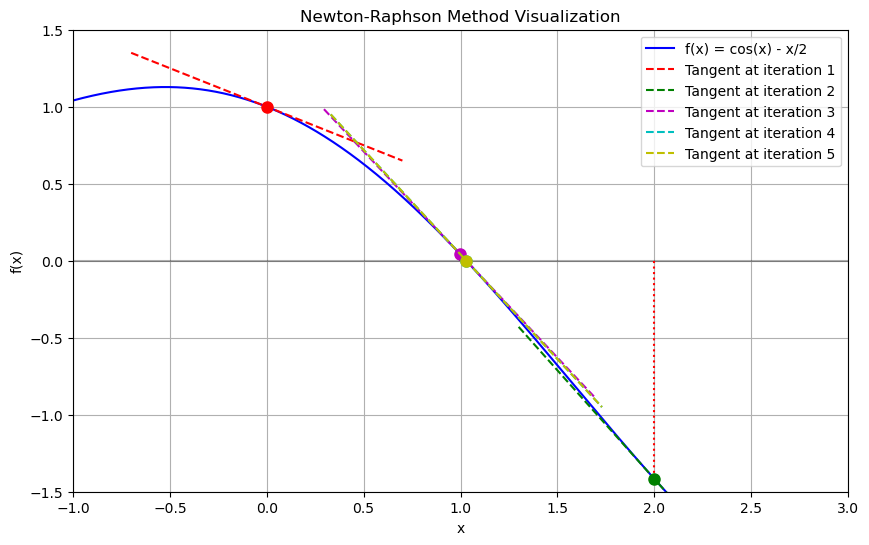

In [2]:
import matplotlib.pyplot as plt

# Demonstrate Newton-Raphson iteration
x = 0.0  # Initial guess
iterations = 5
x_values = [x]

for i in range(iterations):
    x = newton_step(x)
    x_values.append(x)
    print(f"Iteration {i+1}: x = {x:.8f}, f(x) = {f(x):.8f}")

# Visualization
plt.figure(figsize=(10, 6))
x_range = np.linspace(-1, 3, 1000)
plt.plot(x_range, f(x_range), "b-", label="f(x) = cos(x) - x/2")
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)

# Plot each iteration
colors = ["r", "g", "m", "c", "y"]
for i in range(len(x_values) - 1):
    x_current = x_values[i]
    x_next = x_values[i + 1]

    # Plot the current point
    plt.plot(x_current, f(x_current), "o", color=colors[i], markersize=8)

    # Plot the tangent line
    tangent_x = np.linspace(x_current - 0.7, x_current + 0.7, 100)
    tangent_y = f(x_current) + df(x_current) * (tangent_x - x_current)
    plt.plot(
        tangent_x, tangent_y, "--", color=colors[i], label=f"Tangent at iteration {i+1}"
    )

    # Plot the next x value
    plt.plot([x_next, x_next], [0, f(x_next)], color=colors[i], linestyle=":")

plt.grid(True)
plt.legend()
plt.title("Newton-Raphson Method Visualization")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(-1, 3)
plt.ylim(-1.5, 1.5)
plt.show()

This example clearly shows how Newton-Raphson uses tangent lines at each iteration to find the next approximation to the root. Note how the convergence accelerates as we approach the solution near x ≈ 1.03.

### Extension to Systems of Equations

For systems of nonlinear equations, the Newton-Raphson method extends naturally by using the Jacobian matrix:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - [J(\mathbf{x}_k)]^{-1} \mathbf{f}(\mathbf{x}_k)$$

Where:
- $\mathbf{x}_k$ is the vector of variables at iteration $k$
- $\mathbf{f}(\mathbf{x}_k)$ is the vector of function values (residuals)
- $J(\mathbf{x}_k)$ is the Jacobian matrix of partial derivatives

In practice, we don't explicitly calculate the inverse. Instead, we solve the linear system:

$$J(\mathbf{x}_k) \Delta \mathbf{x}_k = -\mathbf{f}(\mathbf{x}_k)$$

And then update: $\mathbf{x}_{k+1} = \mathbf{x}_k + \Delta \mathbf{x}_k$


### Two-Equation Example
Consider this problem from `scipy.optimize.fsolve` documentation:

$$
x_0 \cos(x_1) = 4
$$

$$
x_1 x_0 - x_1 = 5
$$

We can define the residual function and the analytical Jacobian matrix (more on this later) as follows.

In [3]:
def residual(x):
    return np.array([x[0] * np.cos(x[1]) - 4, x[0] * x[1] - x[1] - 5])


def J(x):
    return np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])], [x[1], x[0] - 1]])

Next, we write the Newton method as a function, using an existing linear matrix solver from NumPy.

In [4]:
from numpy.linalg import solve


def newton_raphson(F, J, x0, tol=1e-6, max_iter=20):
    """
    Solve a system of nonlinear equations using Newton-Raphson method.

    Parameters
    ----------
        F - Function that returns the residuals
        J - Function that returns the Jacobian matrix
        x0 - Initial guess
        tol - Convergence tolerance
        max_iter - Maximum number of iterations

    Returns
    -------
        x - Solution vector
        iterations - Number of iterations performed
    """

    x = x0.copy()

    for iter in range(max_iter):
        f = F(x)

        # Early termination if tolerance met
        if np.linalg.norm(f) < tol:
            return x, iter

        jacobian = J(x)

        try:
            dx = solve(jacobian, -f)
        except np.linalg.LinAlgError:
            print("Jacobian matrix is singular.")
            return x, iter

        x = x + dx

        print(f"Iteration {iter+1}: ||f(x)|| = {np.linalg.norm(f):.8f}")

    print("Maximum iterations reached without convergence.")
    return x, max_iter

In [5]:
# Initial guess
x0 = np.array([1.0, 1.0])

# Solve the system
solution, iterations = newton_raphson(residual, J, x0)
print(f"\nSolution: x = {solution[0]:.6f}, y = {solution[1]:.6f}")
print(f"Check: f₁ = {residual(solution)[0]:.8f}, f₂ = {residual(solution)[1]:.8f}")

Iteration 1: ||f(x)|| = 6.08025560
Iteration 2: ||f(x)|| = 4.91726997
Iteration 3: ||f(x)|| = 2.10781410
Iteration 4: ||f(x)|| = 0.38973132
Iteration 5: ||f(x)|| = 0.00769602
Iteration 6: ||f(x)|| = 0.00000361

Solution: x = 6.504097, y = 0.908414
Check: f₁ = -0.00000000, f₂ = 0.00000000


### Convergence Properties

The Newton-Raphson method has several important convergence characteristics:

1. **Quadratic Convergence**: Near a solution, the error approximately squares with each iteration. This means the number of correct digits roughly doubles each step, leading to very fast convergence once you're close enough.

2. **Initial Guess Sensitivity**: The method can be sensitive to the starting point:
   - With a good initial guess, convergence is rapid
   - With a poor initial guess, the method might converge slowly or even diverge
   - Near points where the derivative is zero, the method can behave erratically

3. **Convergence Criteria**: In practice, we typically check both:
   - The residual norm: $||\mathbf{f}(\mathbf{x}_k)|| < \epsilon_f$
   - The step size: $||\Delta \mathbf{x}_k|| < \epsilon_x$

## Numerical Solution using SciPy

### Basic Usage
In practice, we can use off-the-shelf solvers in Python for simple problems.

`fsolve` is a function in `scipy.optimize` for root-finding. We can check the
docstring by typing `?fsolve` in a Jupyter cell or visiting the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html).

In [6]:
from scipy.optimize import fsolve

x0 = np.array([1, 1])
sol = fsolve(residual, x0)
print(sol)

[6.50409711 0.90841421]


In [7]:
np.isclose(residual(sol), [0.0, 0.0])

# The residual at the solution is expected to be close to 0.0.

array([ True,  True])

### Jacobian Matrix

SciPy's `fsolve` uses the [Powell's hybrid
method](https://en.wikipedia.org/wiki/Powell%27s_dog_leg_method), which combines

- Newton-Raphson steps for fast convergence when near the solution
- Gradient descent characteristics for improved stability when far from the solution

This hybrid approach retains the rapid convergence of Newton-Raphson while improving reliability for a wider range of initial guesses. This method requires the Jacobian matrix.

Calculating the Jacobian matrix is computationally expensive. By default,
`fsolve` uses the `hybrd` method in MINPACK, which calculates the numerical Jacobian
matrix using [divided difference](https://en.wikipedia.org/wiki/Divided_differences). For each column of the Jacobian matrix, two
evaluations of the residual functions are needed, resulting in a total of `2N`
residual evaluations for an N-dimensional problem.

Providing the Jacobian matrix can speed up the calculation. This is one of the
reasons why texts on power system analysis always show Jacobian matrix. 

`fsolve` allows specifying the function that provides the Jacobian matrix
through the `fprime` argument.

To clarify, the Jacobian function is the first-order derivatives of the
**residual function** w.r.t the unknown variables. It is not necessarily the
derivative of the **original function** w.r.t the unknown variables.

In our example, the residual function is:

$$
r_0 = 
\begin{bmatrix}
x_0 \cos(x_1) - 4 \\
x_0 x_1 - x_1 - 5
\end{bmatrix}
$$

And since, the unknowns are

$$
x = \begin{bmatrix}
x_0 \\
x_1
\end{bmatrix}
$$

Therefore, the **analytical** Jacobian matrix is:

$$
J = \begin{bmatrix}
\frac{\partial r_0}{\partial x_0} & \frac{\partial r_0}{\partial x_1} \\
\frac{\partial r_1}{\partial x_0} & \frac{\partial r_1}{\partial x_1}
\end{bmatrix} = 
\begin{bmatrix}
\cos(x_1) & -x_0 \sin(x_1) \\
x_1 & x_0 - 1
\end{bmatrix}
$$

It is called the analytical Jacobian matrix because it is derived based on
calculus. 


In [8]:
def jacobian_analytical(x):
    return np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])], [x[1], x[0] - 1]])


sol = fsolve(residual, x0, fprime=jacobian_analytical)
print(sol)

np.isclose(
    residual(sol), [0.0, 0.0]
)  # the residual at the solution should be almost 0.0.

[6.50409711 0.90841421]


array([ True,  True])

In this small example, we cannot see the performance gain from providing the
Jacobian matrix. However, this will be illustrated by a power flow problem.

### Numerical Jacobian Calculation

When we don't specify the Jacobian matrix, `fsolve` (which uses MINPACK under the hood) approximates it using a divided difference approach. Each element of the Jacobian matrix is calculated as:

$$J_{ij} = \frac{\partial f_i}{\partial x_j} \approx \frac{f_i(x + h_j e_j) - f_i(x)}{h_j}$$

where:

- $J_{ij}$ is the $(i,j)$ element of the Jacobian matrix
- $f_i$ is the $i$-th function in the system
- $x_j$ is the $j$-th variable
- $h_j$ is a small step size for variable $j$
- $e_j$ is the unit vector in the direction of $x_j$

Let's implement this numerical approximation to see how it works:

In [9]:
def jacobian_numerical(func, x, eps=1e-6):
    """
    Calculate the Jacobian matrix using finite differences.
    """

    n = len(x)
    f0 = func(x)
    m = len(f0)
    J = np.zeros((m, n))

    for j in range(n):
        # Create a copy of x with a small perturbation in the j-th element
        x_perturbed = x.copy()
        x_perturbed[j] += eps

        # Calculate the perturbed function values
        f1 = func(x_perturbed)

        # Compute the j-th column of the Jacobian
        J[:, j] = (f1 - f0) / eps

    return J

In [10]:
# Example: Calculate the Jacobian for our simple function
x = np.array([1.0, 1.0])
J = jacobian_numerical(residual, x)
print("Numerical Jacobian matrix:")
print(J)


# Compare with the analytical Jacobian at the same point
J_analytical = jacobian_analytical(x)
print("\nAnalytical Jacobian matrix:")
print(J_analytical)

Numerical Jacobian matrix:
[[ 0.54030231 -0.84147125]
 [ 1.          0.        ]]

Analytical Jacobian matrix:
[[ 0.54030231 -0.84147098]
 [ 1.          0.        ]]


### Trade-offs of Numerical Jacobian

While calculating the Jacobian numerically is convenient, it has several drawbacks:

1. **Computational Cost**: For a system with $n$ variables, computing the numerical Jacobian requires at least $n$ additional function evaluations.

2. **Accuracy**: The accuracy of the approximation depends on the choice of step size. Too small may lead to numerical errors due to floating-point precision, while too large may not capture the local derivative correctly.

3. **Performance Impact**: For large systems like power flow equations, providing an analytical Jacobian can significantly improve computational efficiency.

## Handling Convergence Challenges

### Convergence

We talked about "convergence", but what does it mean? Intuitively, it means that
the solution does not change much between iterations. That can be seen from the
previous figure. 

Typically, convergence is checked on the variable between consecutive
iterations. For a specified `xtol`, if the solution satisfies $|x_{k+1} - x_k| <
\text{xtol}$, the solution is deemed converged. This is what is checked by
`fsolve`.

In addition, the residual should be small enough when converged. The tolerance
is often named `ftol`. If the residual satisfies $|f(x_{k+1})| < \text{ftol}$, the solution
is deemed converged.

It is beneficial to check both of them if you are writing a custom solver.

### Initial Guess

Initial guess plays an important role in the solver convergence. An inproper
initial guess may result in failure to converge. Such guesses are said to be
**not in the region of attraction** of the solution.

For example, if we use the initial guess `[0, 0]`, the solver will fail to
converge.


In [11]:
sol = fsolve(residual, [0, 0])

/tmp/ipykernel_1727460/2019346469.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(residual, [0, 0])


The warning message indicates that iterations are not converging in the last ten steps. 

In other cases, a different initial guess may result in a different solution.
Consider the simple equation 

$$x^2 - 1 = 0$$

Starting from `1.2` and `-1.2` will converge to `1` and `-1`, respectively.

In [12]:
def simple_residual(x):
    return np.array([x[0] ** 2 - 1])


sol = fsolve(simple_residual, [1.2])
print("Starting from 1.2, the solution is:", sol)

sol = fsolve(simple_residual, [-1.2])
print("Starting from -1.2, the solution is:", sol)

Starting from 1.2, the solution is: [1.]
Starting from -1.2, the solution is: [-1.]


### Storing History using Python decorator

Let's get into `fsolve` to print out the residual at the solution. 

First, let's enable `full_output=True` to get some extra information, such as the number of
iterations. Options like `full_output` and the corresponding output format can be looked up in
[SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html).


In [13]:
sol, infodict, ier, mesg = fsolve(residual, [0, 0], full_output=True)

print(f"Number of iterations: {infodict['nfev']}")

Number of iterations: 33


Now let's store the `x` and the residual at each step. We will implement it using
a technique called **decorator**.

Decorators can be used to modify the behavior of a function. They are often used
to add extra functionality to a function. 

A decorator *is* a function which *takes* a function as input and *returns* a modified function.


In [14]:
residual_history = []
x_history = []


# `with_history` is a decorator to wrap the callback function
def with_history(func):  # `func` is the function to modify (wrap)
    def wrapper(*args, **kwargs):  # `wrapper` is the modified function to be returned
        residual_history.append(residual(args[0]))
        x_history.append(args[0])
        return func(*args, **kwargs)

    return wrapper

Below is the basic way to use the decorator -- just call the decorator with the
function to be modified. In this way, we did not modify any of the `residual`
code but added extra functionality. Decorators are most powerful when
you have a long function needing new functionality with only external
modifications. 

In [15]:
residual_with_history = with_history(residual)

sol = fsolve(residual_with_history, [0, 0])

/tmp/ipykernel_1727460/865456783.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(residual_with_history, [0, 0])


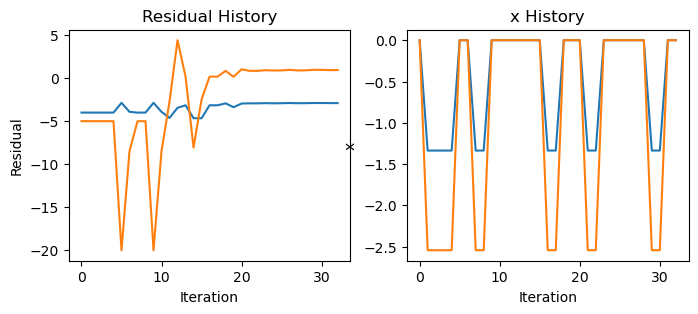

In [16]:
# plot the residual history and `x` history in two figures, side by side

import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(residual_history, x_history):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(residual_history)
    plt.xlabel("Iteration")
    plt.ylabel("Residual")
    plt.title("Residual History")
    plt.subplot(1, 2, 2)
    plt.plot(x_history)
    plt.xlabel("Iteration")
    plt.ylabel("x")
    plt.title("x History")


plot_history(residual_history, x_history)

You can tell that the residual does not converge to zero, and the `x` are
jumping back and forth.

Now let's check the residual and `x` using initial guess `[1, 1]`.



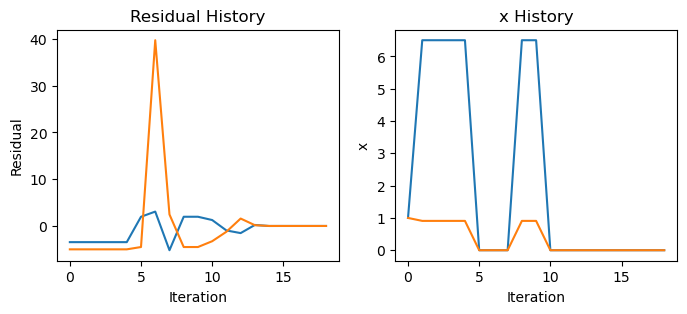

In [17]:
# don't forget to reset the history
residual_history = []
x_history = []

sol = fsolve(residual_with_history, [1, 1])
plot_history(residual_history, x_history)

:::{admonition} More on Decorators

Decorators can be reused to wrap different functions. Suppose we have a
different residual function for which the history is needed. In addition to
writing out the residual function, we can use `@with_history` to wrap it. This
is a syntax sugar provided by Python.

```python
@with_history
def residual2(x):
    return [x[0]**2 + x[1]**2 - 1,
            x[0] + x[1] - 1]
```

:::

### Conclusion

While numerical Jacobian calculation offers convenience, analytical Jacobians provide better performance for complex systems. Understanding both approaches gives you flexibility:

1. Use numerical Jacobians for rapid prototyping and simple problems
2. Implement analytical Jacobians for production code and large-scale systems where performance matters

The choice depends on your specific needs in balancing development time against execution speed.

For our nonlinear equation solving needs, it's valuable to know that even without providing a Jacobian, we can still find solutions efficiently using tools like `fsolve`. However, as problems become complex, the analytical Jacobian can be helpful for computational speed up.

## Quizzes

In [20]:
# Development for new questions

display_quiz("questions/" + "nonlinear-equations.json", colors=color_dict)

<IPython.core.display.Javascript object>

In [ ]:
display_quiz(git_url + "nonlinear-equations.json", 
             colors=color_dict,  
            )